# EE610 - Image Processing 
## Assignment 3
## Jahnvi Singh Rohela 20D070040
## Keshav Singhal 20D070047

In [68]:
import cv2 #importing useful libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,15)
import numpy as np
from skimage.util import random_noise

import pywt #Library PyWavelets (https://pywavelets.readthedocs.io/en/latest/) to implement Wavelet Transform 

In [ ]:
def color_array(img): #Function to store color intensity values in seperate arrays
    h, w = img.shape[:2] #Finds dimensions of image
    img_b = np.zeros((h,w))
    img_g = np.zeros((h,w))
    img_r = np.zeros((h,w))
    
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            img_b[i][j] = img[i][j][0] #Copies the Blue intensities in img_b
            img_g[i][j] = img[i][j][1] #Copies the Green intensities in img_g
            img_r[i][j] = img[i][j][2] #Copies the Red intensities in img_r
    return img_b,img_g,img_r

In [5]:
def array_to_color(img,img_b,img_g,img_r): #Function to restore image from color intensity values in seperate arrays
    h, w = img.shape[:2] #Finds dimensions of image
    
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            img[i][j][0] = img_b[i][j] #Copies the Blue intensities 
            img[i][j][1] = img_g[i][j] #Copies the Green intensities 
            img[i][j][2] = img_r[i][j] #Copies the Red intensities
    return img

### 1. Write the following basic functions
### a. Add additive white Gaussian noise (AWGN) with variable variance to any given image, whether gray scale or color. The noise should be independent in RGB channels for color images. [1]
### b. Measure PSNR (with 255 as the default peak, but it should also be variable) between a restored image and a ground-truth image. Do not import a PSNR function directly, even if available. [1]
### c. Measure SSIM (with power 1 for all three elements -- mean, variance, correlation -- which can be varied too) between a restored and a ground-truth image. Do not import an SSIM function directly, even if available. [1]
### d. Isotropic Gaussian blurring (Gaussian low pass filtering) of an image for a given variance. [1]

In [40]:
#Defining a function to add gaussian noise to image using parameters of mean and standard deviation
def img_noise(image, mean, std): 
    b,g,r = color_array(image)  #Separating channels
    #Adding noise to each channel separately
    noisy_r = r + np.random.normal(mean, std, image.shape[0:2])
    noisy_g = g + np.random.normal(mean, std, image.shape[0:2])
    noisy_b = b + np.random.normal(mean, std, image.shape[0:2])
    return noisy_r, noisy_g, noisy_b

noise_r,noise_g,noise_b = img_noise(clean.copy(),0,10)

In [80]:
# Defining a function to determine PSNR
def psnr(clean_channel, noisy_channel, peak):
    m,n = clean_channel.shape[0:2] #Taking dimensions of image channel
    mse = np.mean((clean_channel-noisy_channel)**2) #Finding mean square error
    PSNR = 10*np.log10((peak)**2/mse) #Formula as stated in Lec. Slides
    return PSNR
    # print(PSNR)

In [79]:
# Defining a function to determine standard deviation
def std_dev(a):
    sum=0
    x = (a-np.mean(a))**2 #Subtracting mean of array 'a' from every element in the array and squaring it
    
    #Spanning through all elements of 'a'
    for i in range(a.shape[0]-1):
        for j in range(a.shape[1]-1):
            sum += x[i][j]

    std = (sum/(a.shape[0]*a.shape[1]-1))**0.5  #Calculating standard deviation
    return std  

In [78]:
# Defining a function to determine covariance between elements of clean and noisy image channels
def corr(clean, noisy):
    sum = 0
    meanc = np.mean(clean) #Taking mean of all elements in 'clean' array
    meann = np.mean(noisy) #Taking mean of all elements in 'noisy' array
    
    #Spanning through all elements of 'clean'
    for i in range(clean.shape[0]):
        for j in range(clean.shape[1]):
            sum += (clean[i][j]-meanc)*(noisy[i][j]-meann)
    cor = sum/(clean.shape[0]*clean.shape[1]-1) #Determining covariance value
    return cor

In [152]:
# Defining a function to determine SSIM for clean image and noisy image channels
def ssim(clean_channel, noisy_channel):
    clean_mean = np.mean(clean_channel) #Taking mean of all elements in 'clean_channel' array
    noisy_mean = np.mean(noisy_channel) #Taking mean of all elements in 'noisy_channel' array

    clean_std_dev = std_dev(clean_channel) #Taking standard deviation of all elements in 'clean_channel' array
    noisy_std_dev = std_dev(noisy_channel) #Taking standard deviation of all elements in 'noisy_channel' array

    cor = corr(clean_channel,noisy_channel) #Finding covariance value between the two channels

    lum = 2*clean_mean*noisy_mean/(clean_mean**2 + noisy_mean**2) #Luminance comparison function
    con = 2*clean_std_dev*noisy_std_dev/(clean_std_dev**2 + noisy_std_dev**2) #Contrast comparison function
    struct = cor/(clean_std_dev*noisy_std_dev) #Structure comparison function
    return lum*con*struct #Returning SSIM value

In [82]:
# Defining a gaussian mask function
def gaussian_mask(mask,x,y,s): #x,y are the co-ordinates of the center and r is the radius
    h, w = mask.shape[:2] #Finds dimensions of mask
    mask_n = mask.copy()
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            dist2 = (x-i)**2 + (y-j)**2 #Finds distance from the center
            mask_n[i][j] = np.exp(-dist2/(2*s**2))
    return mask_n

In [83]:
# Defining a filter function to be used in gaussian low pass filter
def filter_m(dft,mask):
    dft_new = dft.copy()
    h, w = mask.shape[:2] #Finds dimensions of mask
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            dft_new[i][j][0] = dft[i][j][0]*mask[i][j]
            dft_new[i][j][1] = dft[i][j][1]*mask[i][j]
    return dft_new

In [84]:
# Defining a function for Gaussian low pass filter with variance as a parameter 
def glpf(image_channel, sigma):
    m,n = image_channel.shape[0:2] #Shape of image channel
    dft = cv2.dft(np.float32(image_channel),flags = cv2.DFT_COMPLEX_OUTPUT) #Taking DFT of input image
    dft_shift = np.fft.fftshift(dft) #Shifting the DFT to centre of image

    mask = np.ones((m,n),np.float64) 
    mask_g = gaussian_mask(mask,m/2,n/2,sigma)
    dft_filtered = filter_m(dft_shift,mask_g) #Applying filter in fourier domain

    f_ishift = np.fft.ifftshift(dft_filtered) #Computing the inverse DFT
    img_back = cv2.idft(f_ishift) #Obtaining the image back
    img_back_real = img_back[:,:,0]
    img_max = np.amax(img_back_real)
    img_return = 255*img_back_real/img_max #Normalising image values so that they lie in range 0-255
    return img_return


### The functions defined above will be used extensively in Question-2 and 3

### 2. Write the following Denoising functions for wavelet transforms (you can use a library for DWT and IDWT):

### a. Hard thresholding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (threshold should be variable). [1]
### b. Soft threhsolding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (threshold should be variable), and subtract the threshold from those that are above the threshold. [1]
### c. The method proposed in the paper “Image Denoising using Neighbouring Wavelet Coefficients” by Chen et al. [3]

###  We use the PyWavelets Library for computing DWT and IDWT. 
### Our choice of Mother Wavelet function is Debauchies 4 as it is the wavelet of choice in the analysis of Donoho et al. We will restrict ourselves to single level DWT.
### We use the Additive Gaussian Noise Function implemented in Q1 to generate noisy images. Thresholding will be implemented on their Wavelet transforms to generate denoised-images.

In [151]:
clean = cv2.imread('Clean.jpeg') #Reading the clean image
h, w, i = clean.shape #Stores the values of height and width of image in 'h' and 'w'
print("Height = {},  Width = {}, Intensity ={}".format(h, w, i)) #Prints height and width

Height = 533,  Width = 800, Intensity =3


![](Clean.jpeg)

The above is the test image upon which Noise will be added and will be cleaned using Wavelet transform and thresholding

In [6]:
clean_b,clean_g,clean_r = color_array(clean.copy()) #Copying intensity values for BGR into seperate 2-d arrays

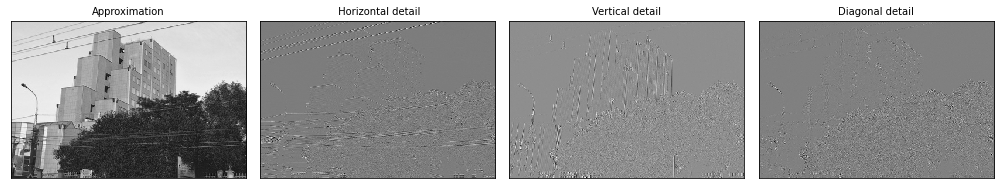

In [7]:
# Wavelet transform of image, and plot approximation and details 
#Credits to https://pywavelets.readthedocs.io/en/latest/
titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail'] 
coeffs2_clean_b = pywt.dwt2(clean_b, 'db4') #Generating the Wavelet Coefficients for Blue Channel
LL, (LH, HL, HH) = coeffs2_clean_b #Storing the Wavelet coefficients for LL,LH,HL,HH respectively
fig = plt.figure(figsize=(14, 4))
for i, a in enumerate([LL, LH, HL, HH]): #Plotting the Wavelet Transform as images
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Above is the Wavelet Transform for Blue Intensity channel of the image

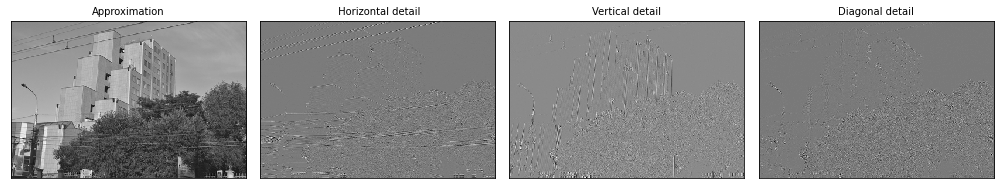

In [8]:
# Wavelet transform of image, and plot approximation and details 
#Credits to https://pywavelets.readthedocs.io/en/latest/
titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail'] 
coeffs2_clean_g = pywt.dwt2(clean_g, 'db4') #Generating the Wavelet Coefficients for Green Channel
LL, (LH, HL, HH) = coeffs2_clean_g #Storing the Wavelet coefficients for LL,LH,HL,HH respectively
fig = plt.figure(figsize=(14, 4))
for i, a in enumerate([LL, LH, HL, HH]): #Plotting the Wavelet Transform as images
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Above is the Wavelet Transform for Green Intensity channel of the image

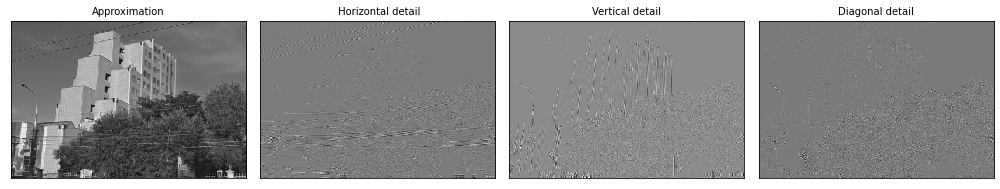

In [9]:
# Wavelet transform of image, and plot approximation and details 
#Credits to https://pywavelets.readthedocs.io/en/latest/
titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail'] 
coeffs2_clean_r = pywt.dwt2(clean_r, 'db4') #Generating the Wavelet Coefficients for Red Channel
LL, (LH, HL, HH) = coeffs2_clean_r #Storing the Wavelet coefficients for LL,LH,HL,HH respectively
fig = plt.figure(figsize=(14, 4))
for i, a in enumerate([LL, LH, HL, HH]): #Plotting the Wavelet Transform as images
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Above is the Wavelet Transform for Red Intensity channel of the image

In [41]:
def noise_cap(noise_img): #Function to limit noise in a channel between 0 and 255
    h, w = noise_img.shape[:2] #Finds dimensions of image
    
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            if(noise_img[i][j] < 0): #If pixel intensity is negative, then cap it to zero
                noise_img[i][j] = 0
            if(noise_img[i][j] > 255): #If pixel intensity is greater than 255, then cap it to 255
                noise_img[i][j] = 255
            
    return noise_img

In [42]:
noise_b = noise_cap(noise_b) #Limiting noise in Blue channel
noise_g = noise_cap(noise_g) #Limiting noise in Green channel
noise_r = noise_cap(noise_r) #Limiting noise in Red channel

In [43]:
noise_img = array_to_color(clean.copy(),noise_b,noise_g,noise_r) #Generating colour image from individual channels

cv2.imwrite('Noise.jpeg',noise_img) #Saves the image

True

![](Noise.jpeg)

Above is the Noisy image

### Taking Wavelet transform for Noisy image channels

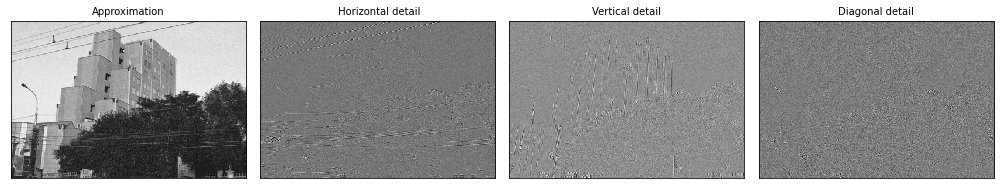

In [14]:
# Wavelet transform of image, and plot approximation and details 
#Credits to https://pywavelets.readthedocs.io/en/latest/
titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail'] 
noise_b_coeffs2 = pywt.dwt2(noise_b, 'db4') #Generating the Wavelet Coefficients for Blue channel
LL_b, (LH, HL, HH) = noise_b_coeffs2 #Storing the Wavelet coefficients for LL,LH,HL,HH respectively
fig = plt.figure(figsize=(14, 4))
for i, a in enumerate([LL_b, LH, HL, HH]): #Plotting the Wavelet Transform as images
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

### Above is the Wavelet Transform for Blue Intensity channel of the noisy image, the added noise is apparent in the LH,HL and HH coeffiecients by how they differ from the clean image

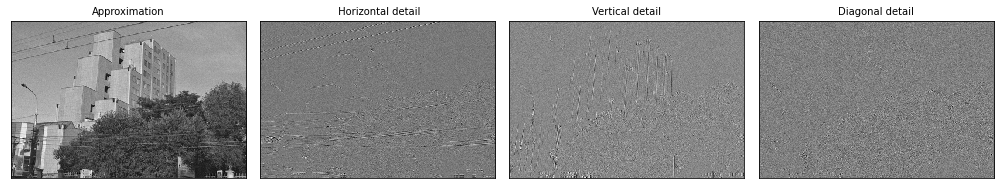

In [15]:
# Wavelet transform of image, and plot approximation and details 
#Credits to https://pywavelets.readthedocs.io/en/latest/
titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail'] 
noise_g_coeffs2 = pywt.dwt2(noise_g, 'db4') #Generating the Wavelet Coefficients for Green channel
LL_g, (LH, HL, HH) = noise_g_coeffs2 #Storing the Wavelet coefficients for LL,LH,HL,HH respectively
fig = plt.figure(figsize=(14, 4))
for i, a in enumerate([LL_g, LH, HL, HH]): #Plotting the Wavelet Transform as images
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

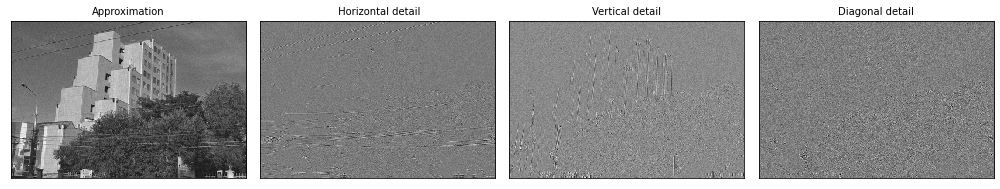

In [16]:
# Wavelet transform of image, and plot approximation and details 
#Credits to https://pywavelets.readthedocs.io/en/latest/
titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail'] 
noise_r_coeffs2 = pywt.dwt2(noise_r, 'db4') #Generating the Wavelet Coefficients for Red channel
LL_r, (LH, HL, HH) = noise_r_coeffs2 #Storing the Wavelet coefficients for LL,LH,HL,HH respectively
fig = plt.figure(figsize=(14, 4))
for i, a in enumerate([LL_r, LH, HL, HH]): #Plotting the Wavelet Transform as images
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [17]:
#From Donoho et al. we shall use λ = 𝜎 sqrt(2log 𝑛^2) as the standard threshold value
import math
def donoho(sigma,h,w):
    l = sigma*np.sqrt(2*math.log(h*w))
    return l

In [18]:
thres_donoho = donoho(10,533,800)
print(thres_donoho) #Value of threshold obtained for above image and noise characteristics

50.917841964941466


### Hard Thresholding

In [19]:
def hard_thres(detail_coeff,thres = thres_donoho): #Function to perform hard thresholding
    #default threshld is the threshold suggested by Donoho et al.
    h, w = detail_coeff.shape[:2] #Finds dimensions of image
    detail_coeff_thres = detail_coeff.copy()
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            if(detail_coeff_thres[i][j] < thres):
                detail_coeff_thres[i][j] = 0 #Sets all values below the threshold to zero
    return detail_coeff_thres

In [64]:
#Function to generate colour image after performing hard thresholding on noisy wavelet coefficients
def hard_thres_img(noise_b_coeffs2, noise_g_coeffs2, noise_r_coeffs2, thres = thres_donoho): 
    denoise_hard_b_LH = hard_thres(noise_b_coeffs2[1][0],thres) #Performing Hard Thresholding on blue channel coefficients
    denoise_hard_b_HL = hard_thres(noise_b_coeffs2[1][1],thres)
    denoise_hard_b_HH = hard_thres(noise_b_coeffs2[1][2],thres)

    denoise_hard_g_LH = hard_thres(noise_g_coeffs2[1][0],thres) #Performing Hard Thresholding on blue channel coefficients
    denoise_hard_g_HL = hard_thres(noise_g_coeffs2[1][1],thres)
    denoise_hard_g_HH = hard_thres(noise_g_coeffs2[1][2],thres)

    denoise_hard_r_LH = hard_thres(noise_r_coeffs2[1][0],thres) #Performing Hard Thresholding on blue channel coefficients
    denoise_hard_r_HL = hard_thres(noise_r_coeffs2[1][1],thres)
    denoise_hard_r_HH = hard_thres(noise_r_coeffs2[1][2],thres)

    restore_b_coeffs2 = noise_b_coeffs2[0],(denoise_hard_b_LH,denoise_hard_b_HL,denoise_hard_b_HH) #Generating Wavelet coefficient tupple to perform IDWT
    restore_g_coeffs2 = noise_g_coeffs2[0],(denoise_hard_g_LH,denoise_hard_g_HL,denoise_hard_g_HH)
    restore_r_coeffs2 = noise_r_coeffs2[0],(denoise_hard_r_LH,denoise_hard_r_HL,denoise_hard_r_HH)
 
    restore_b = pywt.idwt2(restore_b_coeffs2,'db4') #Performing IDWT
    restore_g = pywt.idwt2(restore_g_coeffs2,'db4')
    restore_r = pywt.idwt2(restore_r_coeffs2,'db4')

    restore_b = noise_cap(restore_b) #Limiting pixel valued between 0 and 255
    restore_g = noise_cap(restore_g)
    restore_r = noise_cap(restore_r)

    restore_img = array_to_color(clean.copy(),restore_b,restore_g,restore_r) #Generating colour image from individual channels
    
    return restore_img

In [65]:
#Generating thresholded image for the threshold suggested by Donoho et al.
restore_img_hard_donoho = hard_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, thres_donoho) 
cv2.imwrite('restore_hard_donoho.jpeg',restore_img_hard_donoho) #Saves the image

True

![](restore_hard_donoho.jpeg)

Hard thresholding using a threshold suggested by donoho (50.9) gives a much less noisy image but it costs us a significant amount of detail. Perhaps lowering the threshold will give better results 

In [35]:
#Generating thresholded image for threshold = 20.
restore_img_hard_20 = hard_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, 20) 
cv2.imwrite('restore_hard_20.jpeg',restore_img_hard_20) #Saves the image

True

![](restore_hard_20.jpeg)

Hard thresholding using a threshold of 20 generates an image with nearly the same apparent noise as with the threshold suggested by Donoho et al., however the details are much more pronounced

### Soft Thresholding

In [22]:
def soft_thres(detail_coeff,thres = thres_donoho): #Function to perform soft thresholding
    #default threshld is the threshold suggested by Donoho et al.
    h, w = detail_coeff.shape[:2] #Finds dimensions of image
    detail_coeff_thres = detail_coeff.copy()
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            if(detail_coeff_thres[i][j] < thres):
                detail_coeff_thres[i][j] = 0
            else:
                detail_coeff_thres[i][j] = detail_coeff_thres[i][j] - thres
    return detail_coeff_thres

In [67]:
def soft_thres_img(noise_b_coeffs2, noise_g_coeffs2, noise_r_coeffs2, thres = thres_donoho):
    denoise_soft_b_LH = soft_thres(noise_b_coeffs2[1][0],thres) #Performing Soft Thresholding on blue channel coefficients
    denoise_soft_b_HL = soft_thres(noise_b_coeffs2[1][1],thres)
    denoise_soft_b_HH = soft_thres(noise_b_coeffs2[1][2],thres)

    denoise_soft_g_LH = soft_thres(noise_g_coeffs2[1][0],thres) #Performing Soft Thresholding on green channel coefficients
    denoise_soft_g_HL = soft_thres(noise_g_coeffs2[1][1],thres)
    denoise_soft_g_HH = soft_thres(noise_g_coeffs2[1][2],thres)

    denoise_soft_r_LH = soft_thres(noise_r_coeffs2[1][0],thres) #Performing Soft Thresholding on red channel coefficients
    denoise_soft_r_HL = soft_thres(noise_r_coeffs2[1][1],thres)
    denoise_soft_r_HH = soft_thres(noise_r_coeffs2[1][2],thres)

    #Generating Wavelet coefficient tupple to perform IDWT
    restore_b_coeffs2 = noise_b_coeffs2[0],(denoise_soft_b_LH,denoise_soft_b_HL,denoise_soft_b_HH) 
    restore_g_coeffs2 = noise_g_coeffs2[0],(denoise_soft_g_LH,denoise_soft_g_HL,denoise_soft_g_HH)
    restore_r_coeffs2 = noise_r_coeffs2[0],(denoise_soft_r_LH,denoise_soft_r_HL,denoise_soft_r_HH)

    restore_b = pywt.idwt2(restore_b_coeffs2,'db4') #Performing IDWT
    restore_g = pywt.idwt2(restore_g_coeffs2,'db4')
    restore_r = pywt.idwt2(restore_r_coeffs2,'db4')

    restore_b = noise_cap(restore_b) #Limiting pixel intensities between 0 and 255
    restore_g = noise_cap(restore_g)
    restore_r = noise_cap(restore_r)

    restore_img_soft = array_to_color(clean.copy(),restore_b,restore_g,restore_r) #Generating colour image

    return restore_img_soft

In [85]:
#Generating thresholded image for the threshold suggested by Donoho et al.
restore_img_soft = soft_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, thres_donoho)

cv2.imwrite('restore_soft_donoho.jpeg',restore_img_soft) #Saves the image

True

![](restore_soft_donoho.jpeg)

Soft thresholding gives very similar results to hard thresholding for the same threshold but the details are slightly less pronounced when compared to hard thresholding. Let's perform the same technique for thres = 20

In [86]:
#Generating thresholded image for threshold = 20.
restore_img_soft_20 = soft_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, 20) 
cv2.imwrite('restore_soft_20.jpeg',restore_img_soft_20) #Saves the image

True

![](restore_soft_20.jpeg)

Soft thresholding using a threshold of 20 generates an image with nearly the same apparent noise as with the threshold suggested by Donoho et al., however the details are much more pronounced

### The method proposed in the paper “Image Denoising using Neighbouring Wavelet Coefficients” by Chen et al

We follow the thresholding scheme as suggested by Chen et al with a 3x3 window

In [28]:
def chen_thres(detail_coeff,thres = thres_donoho): #Function to perform thresholding as suggested by Chen et al
    #default threshld is the threshold suggested by Donoho et al.
    h, w = detail_coeff.shape[:2] #Finds dimensions of image
    detail_coeff_thres = detail_coeff.copy()
    detail_coeff_square = detail_coeff.copy()
    
    for i in range(h): #Spans the x-range
        for j in range(w): #Spans the y-range
            detail_coeff_square[i][j] = detail_coeff[i][j]*detail_coeff[i][j] 
            #Calculating the square of all coefficients before hand, gives 9 times advantage in computation
    
    for i in range(1,h-1): #Spans the x-range
        for j in range(1,w-1): #Spans the y-range
            shrinkage = 1 - (thres*thres)/(detail_coeff_square[i-1][j-1]+detail_coeff_square[i][j-1]+detail_coeff_square[i+1][j-1]+detail_coeff_square[i-1][j]+detail_coeff_square[i][j]+detail_coeff_square[i+1][j]+detail_coeff_square[i-1][j+1]+detail_coeff_square[i][j+1]+detail_coeff_square[i+1][j+1])
            #Determined the shrinkage factor using B = 1-(lambda^2/Sjk^2)
            if(shrinkage < 0):
                detail_coeff_thres[i][j] = 0 #If shrinkage factor is negative, sets coefficient value to zero
            else:
                detail_coeff_thres[i][j] = detail_coeff[i][j]*shrinkage #Else, multilpy the shrinkage factor with the coefficient value
    return detail_coeff_thres

In [124]:
def chen_thres_img(noise_b_coeffs2, noise_g_coeffs2, noise_r_coeffs2, thres = thres_donoho):
    denoise_chen_b_LH = chen_thres(noise_b_coeffs2[1][0],thres) #Performing Neighshrink Thresholding on blue channel coefficients
    denoise_chen_b_HL = chen_thres(noise_b_coeffs2[1][1],thres)
    denoise_chen_b_HH = chen_thres(noise_b_coeffs2[1][2],thres)
    
    denoise_chen_g_LH = chen_thres(noise_g_coeffs2[1][0],thres) #Performing Neighshrink Thresholding on blue channel coefficients
    denoise_chen_g_HL = chen_thres(noise_g_coeffs2[1][1],thres)
    denoise_chen_g_HH = chen_thres(noise_g_coeffs2[1][2],thres)

    denoise_chen_r_LH = chen_thres(noise_r_coeffs2[1][0],thres) #Performing Neighshrink Thresholding on blue channel coefficients
    denoise_chen_r_HL = chen_thres(noise_r_coeffs2[1][1],thres)
    denoise_chen_r_HH = chen_thres(noise_r_coeffs2[1][2],thres)
    
    #Generating Wavelet coefficient tupple to perform IDWT
    restore_b_coeffs2 = noise_b_coeffs2[0],(denoise_chen_b_LH,denoise_chen_b_HL,denoise_chen_b_HH)
    restore_g_coeffs2 = noise_g_coeffs2[0],(denoise_chen_g_LH,denoise_chen_g_HL,denoise_chen_g_HH)
    restore_r_coeffs2 = noise_r_coeffs2[0],(denoise_chen_r_LH,denoise_chen_r_HL,denoise_chen_r_HH)

    restore_b = pywt.idwt2(restore_b_coeffs2,'db4') #Performing IDWT
    restore_g = pywt.idwt2(restore_g_coeffs2,'db4')
    restore_r = pywt.idwt2(restore_r_coeffs2,'db4')

    restore_b = noise_cap(restore_b) #Limiting pixel intensities between 0 and 255
    restore_g = noise_cap(restore_g)
    restore_r = noise_cap(restore_r)

    
    restore_img_chen = array_to_color(clean.copy(),restore_b,restore_g,restore_r)  #Generating colour image


    return restore_img_chen

In [31]:
restore_img_chen = chen_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, thres_donoho)

cv2.imwrite('restore_chen.jpeg',restore_img_chen) #Saves the truncated image

True

![](restore_chen.jpeg)

### The image generated by performing NeighShrink thresholding as suggested by Chen et al. has much better noise reduction with much lesser loss of detail as compared to Hard and Soft thresholding. The result is as expected

### 3. Compare PSNR and SSIM (with plots) when you vary the noisy added to clean color images by varying:
### a. Noise variance [1]
### b. Gaussian low pass filtering with various variances [1]
### c. The two thresholding methods, where threshold is given by λ = 𝜎 2 log 𝑛2 (as suggested by Donoho et al.), where 𝜎 is noise variance, and 𝑛 is window size. [2]
### d. The method of Chen et al. [2]
### e. When the method is independently applied to RGB channels, versus when the method is applied to I channel of HSI transform. [2]

In [89]:
# Defining function to plot PSNR and SSIM between clean and noisy image on varying noise variance
def plot_noise(img):
    # Initializing arrays corresponding to PSNR and SSIM values
    PSNR_r = [0]*30
    PSNR_g = [0]*30
    PSNR_b = [0]*30
    SSIM_r = [0]*30
    SSIM_g = [0]*30
    SSIM_b = [0]*30

    for i in range(1,31):#Varying noise standard deviation from 1 to 30
        nr, ng, nb = img_noise(img.copy(), 0, i)  #Separating channels
        noise_r = noise_cap(nr) #Limiting noise in Blue channel
        noise_g = noise_cap(ng) #Limiting noise in Green channel
        noise_b = noise_cap(nb) #Limiting noise in Red channel

        noisy_img=np.dstack((noise_b,noise_g,noise_r)) #Combining RGB channels
        
        #Finding PSNR between clean and noisy image for every channel separately
        PSNR_r[i-1] = psnr(img[:,:,2], noisy_img[:,:,2], 255)
        PSNR_g[i-1] = psnr(img[:,:,1], noisy_img[:,:,1], 255)
        PSNR_b[i-1] = psnr(img[:,:,0], noisy_img[:,:,0], 255)

        #Finding SSIM between clean and noisy image for every channel separately
        SSIM_r[i-1] = ssim(img[:,:,2], noisy_img[:,:,2])
        SSIM_g[i-1] = ssim(img[:,:,1], noisy_img[:,:,1])
        SSIM_b[i-1] = ssim(img[:,:,0], noisy_img[:,:,0])

        x = np.arange(1,31) #Creating an array from 1 to 30 

    # Plotting PSNR for RGB channels
    plt.subplot(1, 2, 1)
    plt.plot(x,PSNR_r,'r',label = "Red")
    plt.plot(x,PSNR_g,'g',label = "Green")
    plt.plot(x,PSNR_b,'b',label = "Blue")
    plt.legend()
    plt.title("PSNR with varying Noise")
    plt.xlabel('Gaussian Noise std. dev.') 
    plt.ylabel('PSNR') 

    # Plotting SSIM for RGB channels
    plt.subplot(1, 2, 2)
    plt.plot(x,SSIM_r,'r',label = "Red")
    plt.plot(x,SSIM_g,'g',label = "Green")
    plt.plot(x,SSIM_b,'b',label = "Blue")
    plt.legend()
    plt.title("SSIM with varying Noise")
    plt.xlabel('Gaussian Noise std. dev.') 
    plt.ylabel('SSIM') 
    
    plt.rcParams.update({'font.size': 50})
    plt.show()  

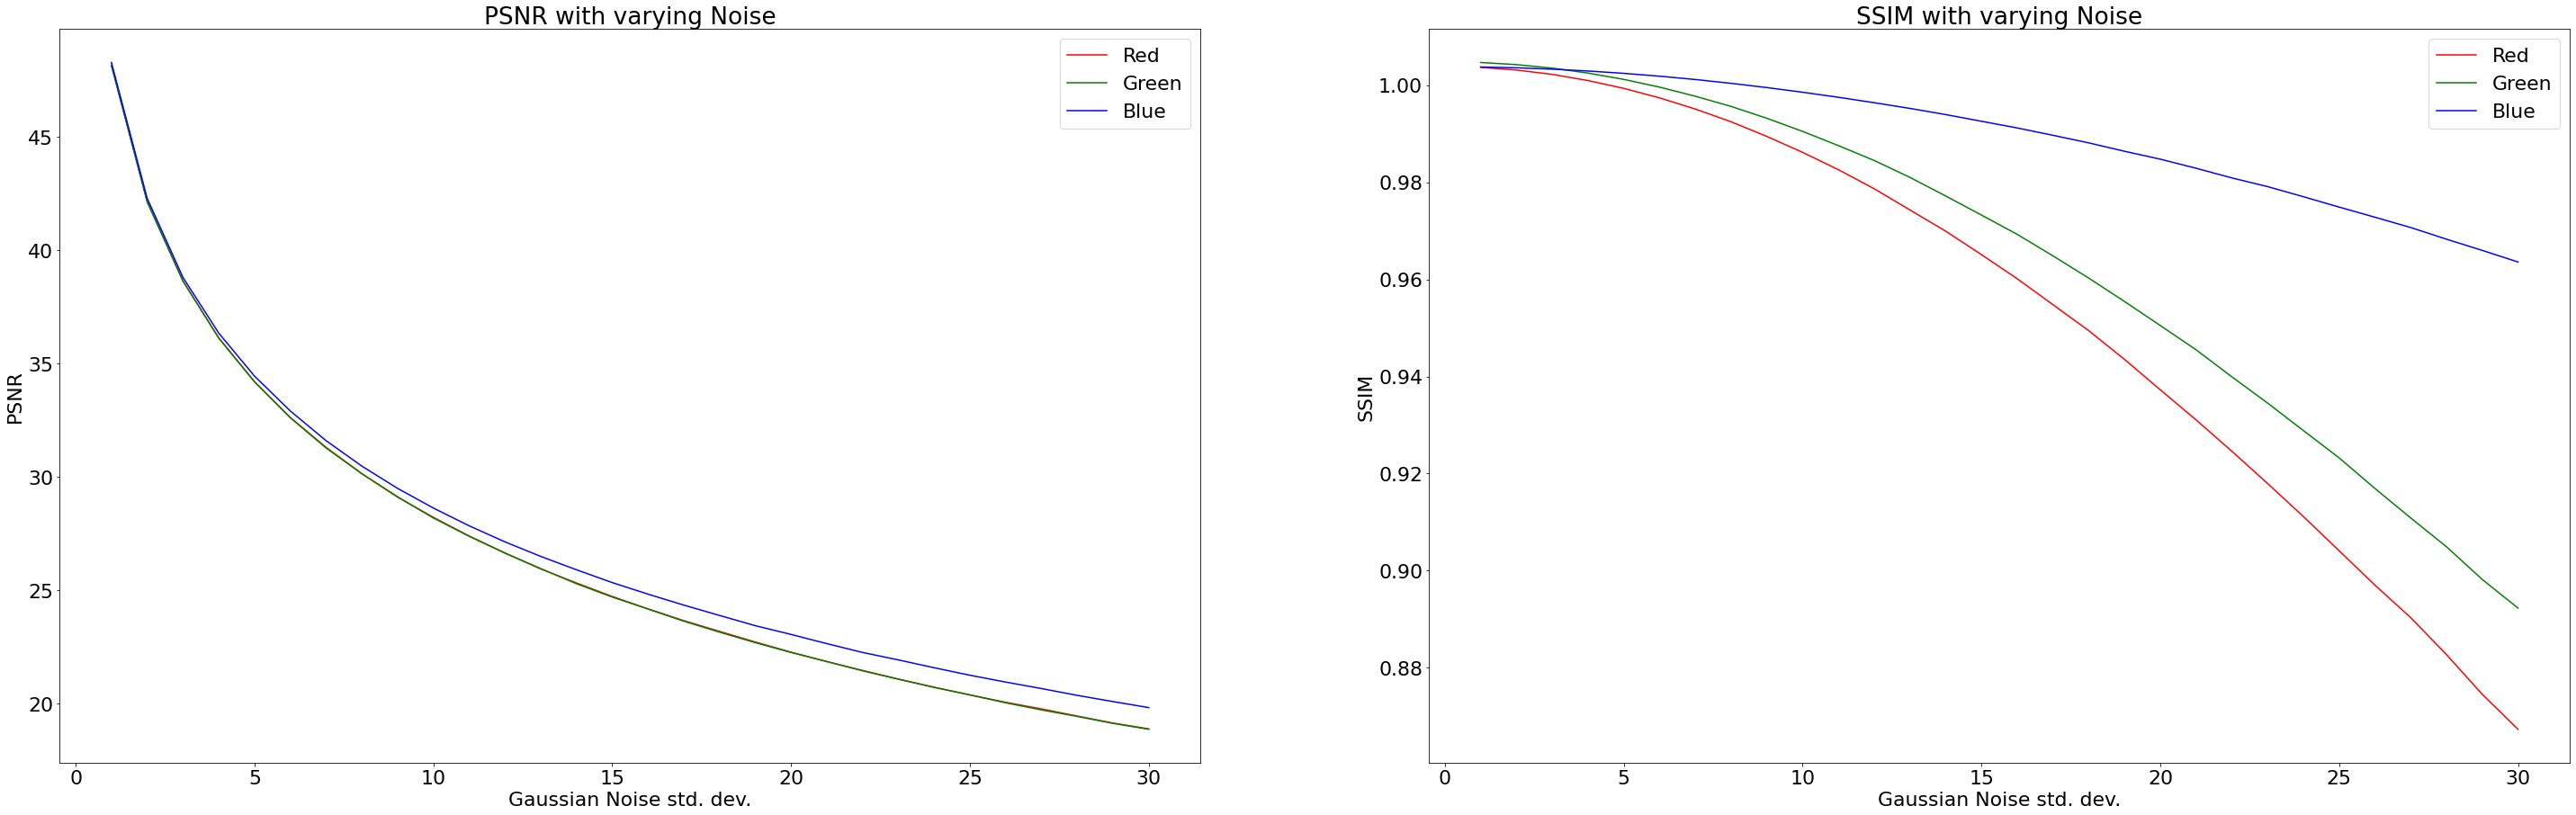

In [90]:
plot_noise(clean.copy())

### From the plots obtained above it is apparent that as the noise content added increases, the PSNR and SSIM between the clean and the noisy image decrease which is according to expectation. 
### The PSNR decreases in a hyberbolic manner and will slowly tend to zero as Noise added is increased further. SSIM shows a decline which increases with more added noise and thus will eventually reach zero as well.

In [104]:
# Defining a function to plot PSNR and SSIM between clean and gaussian low pass filtered image on varying its variance
def plot_gaussian(img):
    PSNR_r = [0]*30
    PSNR_g = [0]*30
    PSNR_b = [0]*30
    SSIM_r = [0]*30
    SSIM_g = [0]*30
    SSIM_b = [0]*30
    for i in range(1,31): #Varying variance of gaussian LPF from 1 to 30
        gauss_r = glpf(img[:,:,2], i)
        gauss_g = glpf(img[:,:,1], i)
        gauss_b = glpf(img[:,:,0], i)

        cap_r = noise_cap(gauss_r) #Limiting noise in Blue channel
        cap_g = noise_cap(gauss_g) #Limiting noise in Green channel
        cap_b = noise_cap(gauss_b) #Limiting noise in Red channel

        #Finding PSNR between clean and filtered image for every channel separately
        PSNR_r[i-1] = psnr(img[:,:,2],gauss_r, 255)
        PSNR_g[i-1] = psnr(img[:,:,1],gauss_g, 255)
        PSNR_b[i-1] = psnr(img[:,:,0],gauss_b, 255)

        #Finding SSIM between clean and filtered image for every channel separately
        SSIM_r[i-1] = ssim(img[:,:,2], gauss_r)
        SSIM_g[i-1] = ssim(img[:,:,1], gauss_g)
        SSIM_b[i-1] = ssim(img[:,:,0], gauss_b)

    x = np.arange(1,31) #Creating an array from 1 to 30

     # Plotting PSNR for RGB channels
    plt.subplot(1, 2, 1)
    plt.plot(x,PSNR_r,'r',label = "Red")
    plt.plot(x,PSNR_g,'g',label = "Green")
    plt.plot(x,PSNR_b,'b',label = "Blue")
    plt.legend()
    plt.title("PSNR with varying Std. Dev. of GLPF")
    plt.xlabel('Gaussian Low Pass FIlter std. dev.') 
    plt.ylabel('PSNR') 

    # Plotting SSIM for RGB channels
    plt.subplot(1, 2, 2)
    plt.plot(x,SSIM_r,'r',label = "Red")
    plt.plot(x,SSIM_g,'g',label = "Green")
    plt.plot(x,SSIM_b,'b',label = "Blue")
    plt.legend()
    plt.title("SSIM with varying Std. Dev. of GLPF")
    plt.xlabel('Gaussian Low Pass Filter std. dev.') 
    plt.ylabel('SSIM') 
    
    plt.rcParams.update({'font.size': 30})
    plt.show()  

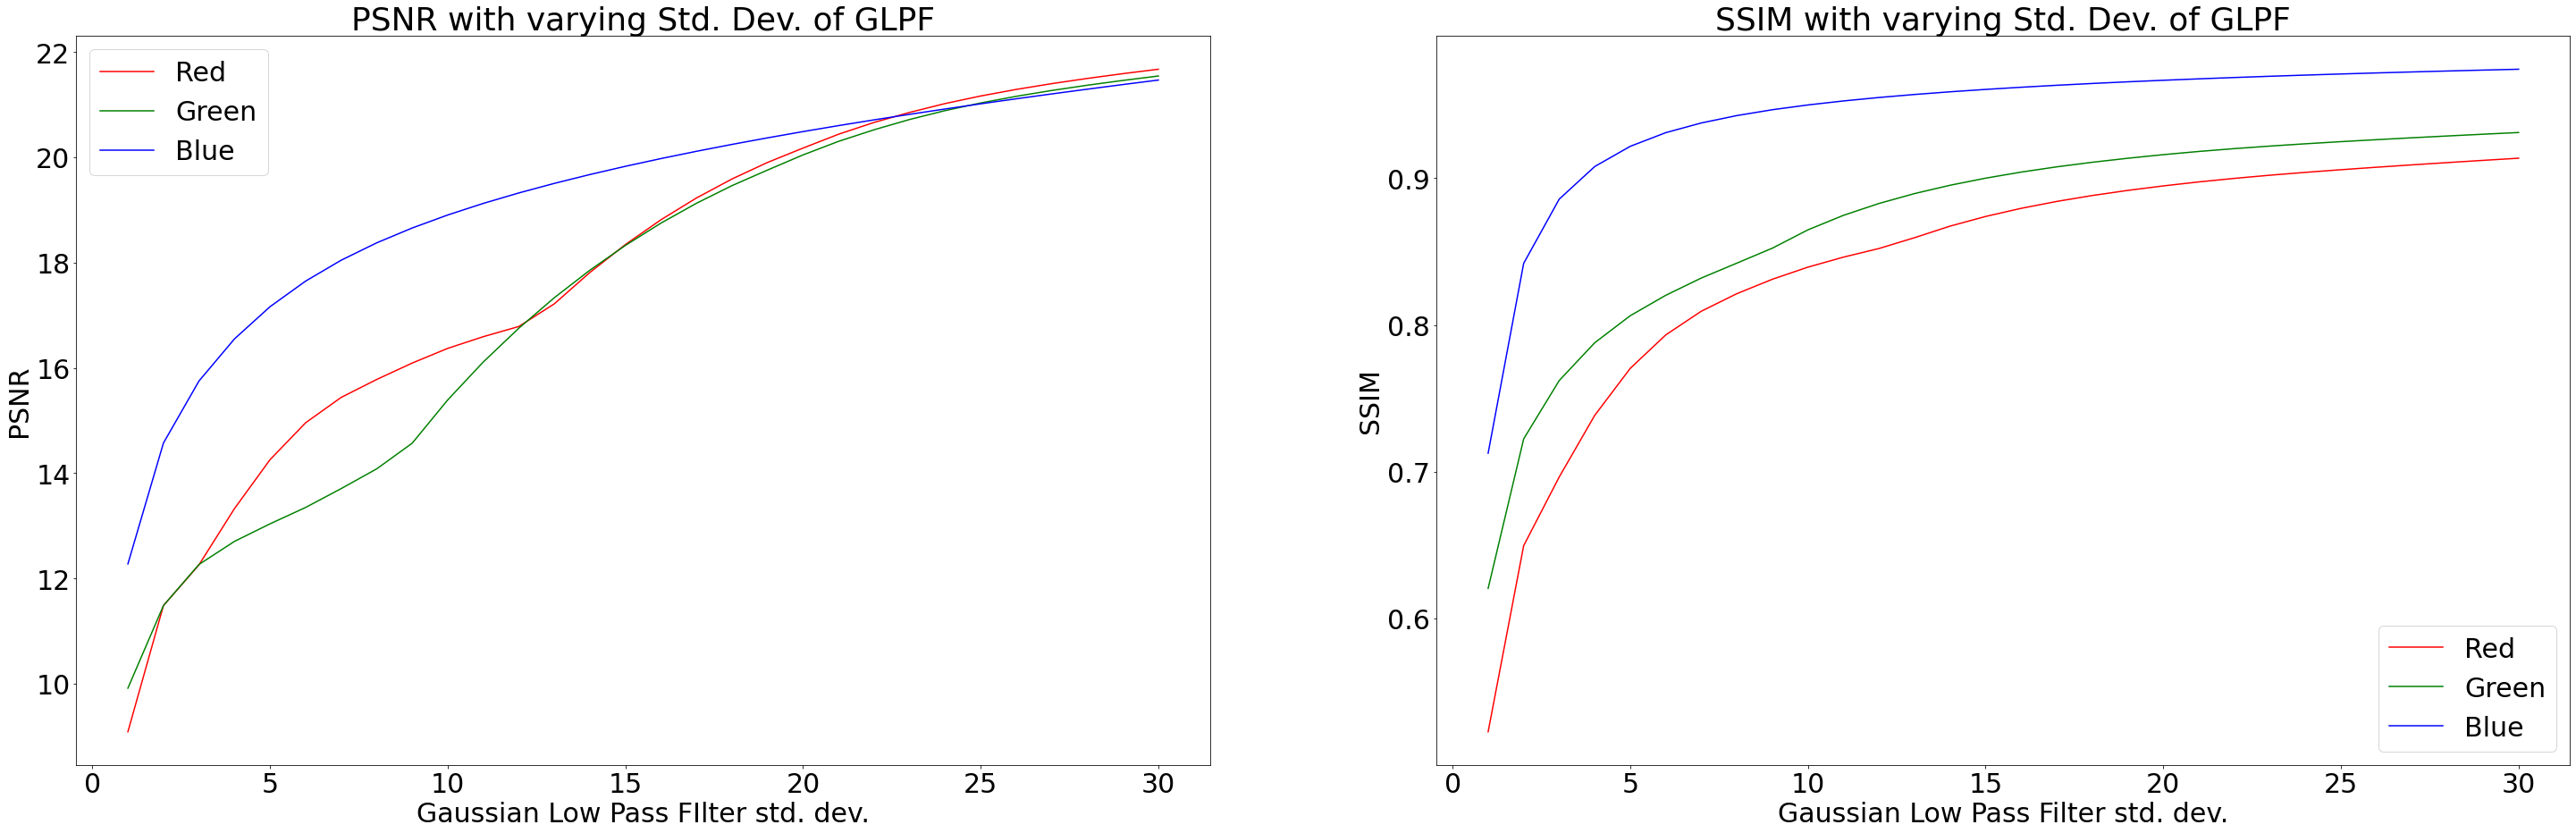

In [105]:
plot_gaussian(clean.copy())

### As the standard deviation of Gaussian Low pass filter increases, it becomes less steeper and thus introduces less filtering/blurring
### From the plots of PSNR and SSIM, it follows our expectations that with increasing std. dev. of GLPF, their respective values will increase as the Filtered image becomes more and more similar to the clean image

In [100]:
# Defining a function to plot PSNR and SSIM comparing Hard thresholding and Soft thresholding methods with varying noise variance
def plot_thresh(img):
    PSNR_r_hard = [0]*30
    PSNR_g_hard = [0]*30
    PSNR_b_hard = [0]*30
    SSIM_r_hard = [0]*30
    SSIM_g_hard = [0]*30
    SSIM_b_hard = [0]*30
    PSNR_r_soft = [0]*30
    PSNR_g_soft = [0]*30
    PSNR_b_soft = [0]*30
    SSIM_r_soft = [0]*30
    SSIM_g_soft = [0]*30
    SSIM_b_soft = [0]*30
    for i in range(1,31): #Varying standard deviation of added  gaussian noise from 1 to 30
        
        noise_r,noise_g,noise_b = img_noise(img.copy(),0,i)
        
        noise_b_coeffs2 = pywt.dwt2(noise_b, 'db4') #Generating the Wavelet Coefficients for Blue channel
        noise_g_coeffs2 = pywt.dwt2(noise_g, 'db4') #Generating the Wavelet Coefficients for Green channel
        noise_r_coeffs2 = pywt.dwt2(noise_r, 'db4') #Generating the Wavelet Coefficients for Red channel
        
        thres_donoho = donoho(i,533,800) #Calculating the threshold suggested by Donoho et el. for varying noise variances
        
        #Performing Hard Thresholding
        restore_img_hard_donoho = hard_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, thres_donoho)
        
        #Finding PSNR between clean and threshold generated image for every channel separately
        PSNR_r_hard[i-1] = psnr(img[:,:,2],restore_img_hard_donoho[:,:,2], 255)
        PSNR_g_hard[i-1] = psnr(img[:,:,1],restore_img_hard_donoho[:,:,1], 255)
        PSNR_b_hard[i-1] = psnr(img[:,:,0],restore_img_hard_donoho[:,:,0], 255)

        #Finding SSIM between clean and threshold generated image for every channel separately
        SSIM_r_hard[i-1] = ssim(img[:,:,2],restore_img_hard_donoho[:,:,2])
        SSIM_g_hard[i-1] = ssim(img[:,:,1],restore_img_hard_donoho[:,:,1])
        SSIM_b_hard[i-1] = ssim(img[:,:,0],restore_img_hard_donoho[:,:,0])
        
        
        #Performing Soft Thresholding
        restore_img_soft_donoho = soft_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, thres_donoho)
        
        #Finding PSNR between clean and threshold generated image for every channel separately
        PSNR_r_soft[i-1] = psnr(img[:,:,2],restore_img_soft_donoho[:,:,2], 255)
        PSNR_g_soft[i-1] = psnr(img[:,:,1],restore_img_soft_donoho[:,:,1], 255)
        PSNR_b_soft[i-1] = psnr(img[:,:,0],restore_img_soft_donoho[:,:,0], 255)
    
        #Finding SSIM between clean and threshold generated image for every channel separately
        SSIM_r_soft[i-1] = ssim(img[:,:,2],restore_img_soft_donoho[:,:,2])
        SSIM_g_soft[i-1] = ssim(img[:,:,1],restore_img_soft_donoho[:,:,1])
        SSIM_b_soft[i-1] = ssim(img[:,:,0],restore_img_soft_donoho[:,:,0])
        
        

    x = np.arange(1,31) #Creating an array from 1 to 30

    # Plotting PSNR for RGB channels
    plt.subplot(2, 3, 1)
    plt.plot(x,PSNR_r_hard,'c',label = "Hard Threshold")
    plt.plot(x,PSNR_r_soft,'m',label = "Soft Threshold")
    plt.legend()
    plt.title("PSNR of Red Channel with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('PSNR') 
    
    plt.subplot(2, 3, 2)
    plt.plot(x,PSNR_g_hard,'c',label = "Hard Threshold")
    plt.plot(x,PSNR_g_soft,'m',label = "Soft Threshold")
    plt.legend()
    plt.title("PSNR of Green Channel with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('PSNR') 
    
    plt.subplot(2, 3, 3)
    plt.plot(x,PSNR_b_hard,'c',label = "Hard Threshold")
    plt.plot(x,PSNR_b_soft,'m',label = "Soft Threshold")
    plt.legend()
    plt.title("PSNR of Blue Channel with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('PSNR') 
    
    # Plotting SSIM for RGB channels 
    plt.subplot(2, 3, 4)
    plt.plot(x,SSIM_r_hard,'c',label = "Hard Threshold")
    plt.plot(x,SSIM_r_soft,'m',label = "Soft Threshold")
    plt.legend()
    plt.title("SSIM of Red Channel with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('SSIM') 
    
    plt.subplot(2, 3, 5)
    plt.plot(x,SSIM_g_hard,'c',label = "Hard Threshold")
    plt.plot(x,SSIM_g_soft,'m',label = "Soft Threshold")
    plt.legend()
    plt.title("SSIM of Green Channel with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('SSIM')
    
    plt.subplot(2, 3, 6)
    plt.plot(x,SSIM_b_hard,'c',label = "Hard Threshold")
    plt.plot(x,SSIM_b_soft,'m',label = "Soft Threshold")
    plt.legend()
    plt.title("SSIM of Blue Channel with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('SSIM')
    
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()
    plt.show()  

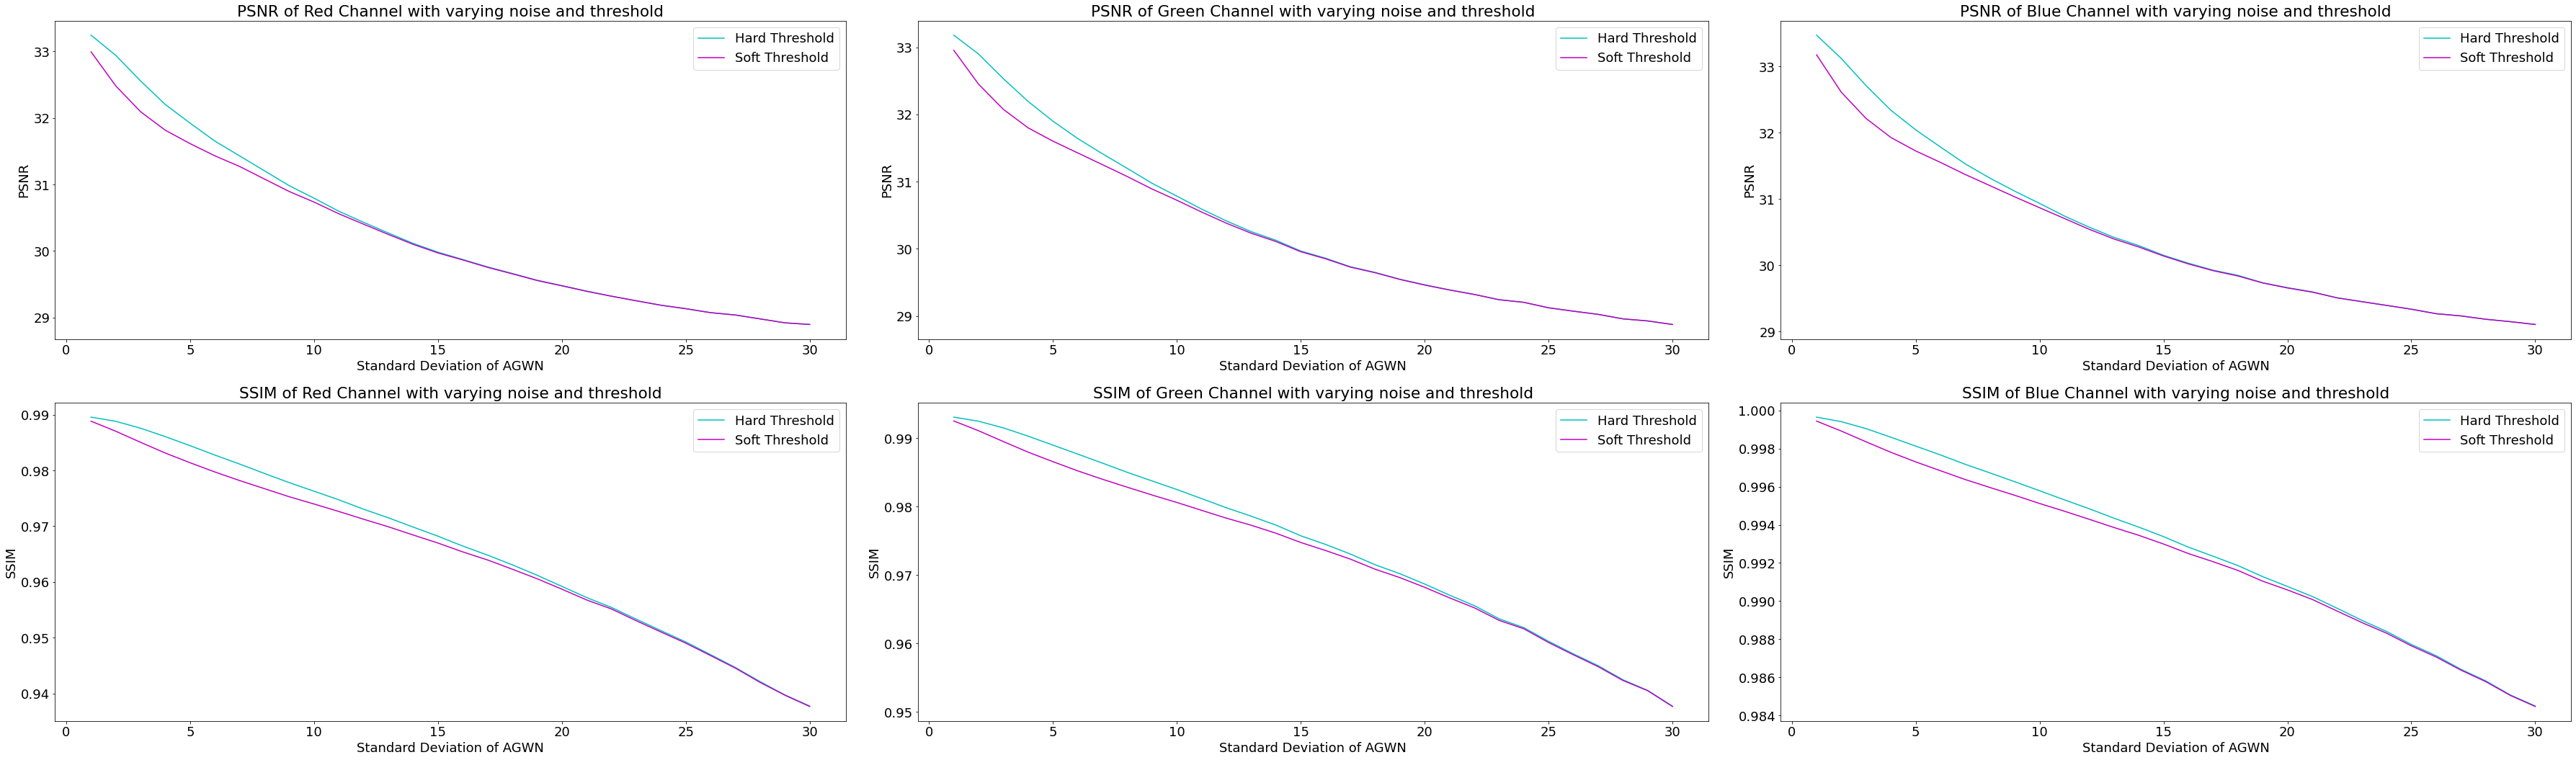

In [101]:
plot_thresh(clean.copy())

### From the plots obtained across all channels, we can compare the methods of Hard thresholding and Soft thresholding. As the Noise variance is increased, the values of PSNR and SSIM for both Hard and Soft thresholding decrease, but Hard thresholding has greater values for both PSNR and SSIM than Soft thresholding for every noise variance.
### It fits our earlier observation that for the same value of noise variance and threshold, Soft thresholding had lesser details compared to Hard thresholding, and thus lesser PSNR and SSIM. However, As the noise variance is increased, both methods give similar results.

In [102]:
# Defining a function to plot PSNR and SSIM for NeighShrink, the method suggested by Chen et al., with varying noise variance
def plot_thresh_chen(img):
    PSNR_r = [0]*30
    PSNR_g = [0]*30
    PSNR_b = [0]*30
    SSIM_r = [0]*30
    SSIM_g = [0]*30
    SSIM_b = [0]*30
    for i in range(1,31): #Varying standard deviation of added  gaussian noise from 1 to 30
        
        noise_r,noise_g,noise_b = img_noise(img.copy(),0,i)
        
        noise_b_coeffs2 = pywt.dwt2(noise_b, 'db4') #Generating the Wavelet Coefficients for Blue channel
        noise_g_coeffs2 = pywt.dwt2(noise_g, 'db4') #Generating the Wavelet Coefficients for Green channel
        noise_r_coeffs2 = pywt.dwt2(noise_r, 'db4') #Generating the Wavelet Coefficients for Red channel
        
        thres_donoho = donoho(i,533,800) #Calculating the threshold suggested by Donoho et el. for varying noise variances
        
        #Performing Thresholding by Neighshrink
        restore_img_chen = chen_thres_img(noise_b_coeffs2,noise_g_coeffs2, noise_r_coeffs2, thres_donoho) 
        
        #Finding PSNR between clean and threshold generated image for every channel separately
        PSNR_r[i-1] = psnr(img[:,:,2],restore_img_chen[:,:,2], 255)
        PSNR_g[i-1] = psnr(img[:,:,1],restore_img_chen[:,:,1], 255)
        PSNR_b[i-1] = psnr(img[:,:,0],restore_img_chen[:,:,0], 255)

        #Finding SSIM between clean and threshold generated image for every channel separately
        SSIM_r[i-1] = ssim(img[:,:,2],restore_img_chen[:,:,2])
        SSIM_g[i-1] = ssim(img[:,:,1],restore_img_chen[:,:,1])
        SSIM_b[i-1] = ssim(img[:,:,0],restore_img_chen[:,:,0])
        
        
        

    x = np.arange(1,31) #Creating an array from 1 to 30

   # Plotting PSNR for RGB channels
    plt.subplot(1, 2, 1)
    plt.plot(x,PSNR_r,'r',label = "Red")
    plt.plot(x,PSNR_g,'g',label = "Green")
    plt.plot(x,PSNR_b,'b',label = "Blue")
    plt.legend()
    plt.title("PSNR with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('PSNR') 

    # Plotting SSIM for RGB channels
    plt.subplot(1, 2, 2)
    plt.plot(x,SSIM_r,'r',label = "Red")
    plt.plot(x,SSIM_g,'g',label = "Green")
    plt.plot(x,SSIM_b,'b',label = "Blue")
    plt.legend()
    plt.title("SSIM with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('SSIM') 
    
    plt.rcParams.update({'font.size': 30})
    plt.tight_layout()
    plt.show()  

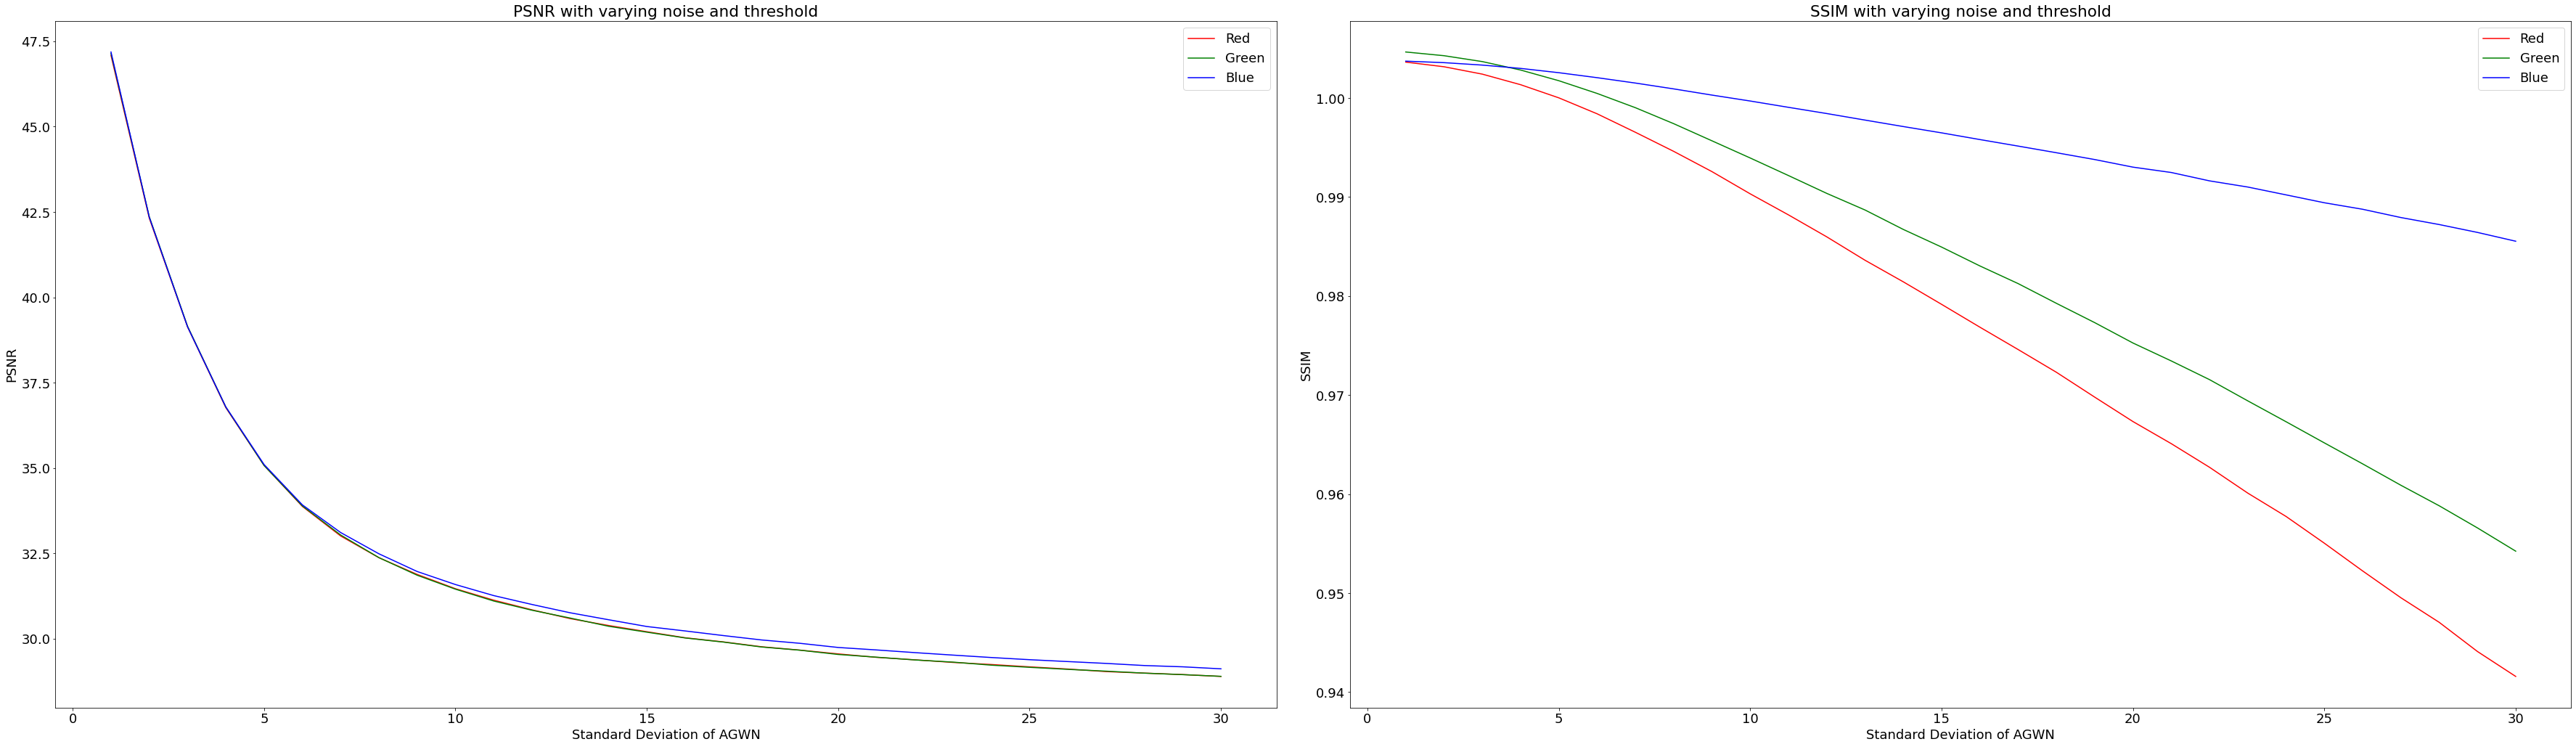

In [103]:
plot_thresh_chen(clean.copy())

### Similar to the trend in Hard thresholding and Soft thresholding, the values of PSNR and SSIM decrease as the noise content in the image is increased. However it is worth noting that the respective values of PSNR and SSIM are significantly greater than the ones calculated for Hard and Soft thresholding for the same Noise variance. 
### NeighShrink gives the best PSNR and SSIM for any value of added noise to the image. Thus proving that it's the best thresholding method among the three. 

In [190]:
def plot_chen_hsi(img):
    PSNR_r = [0]*30
    PSNR_g = [0]*30
    PSNR_b = [0]*30
    SSIM_r = [0]*30
    SSIM_g = [0]*30
    SSIM_b = [0]*30

    for i in range(1,31): #Varying standard deviation of added gaussian noise from 1 to 30
        hsv_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV) # convert image from RGB to HSV
        hsv_img_noise=hsv_img.copy()
        hsv_img_noise[:,:,2] = hsv_img[:,:,2] + np.random.normal(0, i, img.shape[0:2])

        noise_i_coeffs2 = pywt.dwt2(hsv_img_noise[:,:,2], 'db4') #Generating the Wavelet Coefficients for I channel
        LL_i, (LH, HL, HH) = noise_i_coeffs2 #Storing the Wavelet coefficients for LL,LH,HL,HH respectively
        thres_donoho = donoho(i,533,800) #Calculating the threshold suggested by Donoho et el. for varying noise variances

        denoise_chen_i_LH = chen_thres(noise_i_coeffs2[1][0],thres_donoho) #Performing Neighshrink Thresholding on blue channel coefficients
        denoise_chen_i_HL = chen_thres(noise_i_coeffs2[1][1],thres_donoho)
        denoise_chen_i_HH = chen_thres(noise_i_coeffs2[1][2],thres_donoho)

        #Generating Wavelet coefficient tupple to perform IDWT
        restore_i_coeffs2 = noise_i_coeffs2[0],(denoise_chen_i_LH,denoise_chen_i_HL,denoise_chen_i_HH)
        restore_i = pywt.idwt2(restore_i_coeffs2,'db4') #Performing IDWT
        restore_i = noise_cap(restore_i) #Limiting pixel intensities between 0 and 255
        restore_img_hsv = array_to_color(img.copy(),hsv_img_noise[:,:,0],hsv_img_noise[:,:,1],restore_i[:-1]) #Generating HSI image
        restore_img_hsv = np.float32(restore_img_hsv) 
        restore_img_chen = cv2.cvtColor(restore_img_hsv, cv2.COLOR_HSV2BGR)#Coverting HSI image back to RGB
        
        restore_img_chen_b,restore_img_chen_g,restore_img_chen_r = color_array(restore_img_chen)
        
        restore_img_chen_max0 = np.amax(restore_img_chen_b) #Finding min and max to normalize the pixel values
        #print(restore_img_chen_max0)
        restore_img_chen_max1 = np.amax(restore_img_chen_g)
        #print(restore_img_chen_max1)
        restore_img_chen_max2 = np.amax(restore_img_chen_r)
        #print(restore_img_chen_max2)
        restore_img_chen_b = 255*(restore_img_chen_b/restore_img_chen_max0) #Normalising image values so that they lie in range 0-255
        restore_img_chen_g = 255*(restore_img_chen_g/restore_img_chen_max1) #Normalising image values so that they lie in range 0-255
        restore_img_chen_r = 255*(restore_img_chen_r/restore_img_chen_max2) #Normalising image values so that they lie in range 0-255
        
        restore_img_chen = array_to_color(img.copy(),restore_img_chen_b,restore_img_chen_g,restore_img_chen_r)
        #print(restore_img_chen)
        
        #Finding PSNR between clean and threshold generated image for every channel separately
        PSNR_r[i-1] = psnr(img[:,:,2],restore_img_chen[:,:,2], 255)
        PSNR_g[i-1] = psnr(img[:,:,1],restore_img_chen[:,:,1], 255)
        PSNR_b[i-1] = psnr(img[:,:,0],restore_img_chen[:,:,0], 255)

        #Finding SSIM between clean and threshold generated image for every channel separately
        SSIM_r[i-1] = ssim(img[:,:,2],restore_img_chen[:,:,2])
        SSIM_g[i-1] = ssim(img[:,:,1],restore_img_chen[:,:,1])
        SSIM_b[i-1] = ssim(img[:,:,0],restore_img_chen[:,:,0])    

    x = np.arange(1,31) #Creating an array from 1 to 30

    # Plotting PSNR for RGB channels
    plt.subplot(1, 2, 1)
    plt.plot(x,PSNR_r,'r',label = "Red")
    plt.plot(x,PSNR_g,'g',label = "Green")
    plt.plot(x,PSNR_b,'b',label = "Blue")
    plt.legend()
    plt.title("PSNR with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('PSNR') 

    # Plotting SSIM for RGB channels
    plt.subplot(1, 2, 2)
    plt.plot(x,SSIM_r,'r',label = "Red")
    plt.plot(x,SSIM_g,'g',label = "Green")
    plt.plot(x,SSIM_b,'b',label = "Blue")
    plt.legend()
    plt.title("SSIM with varying noise and threshold")
    plt.xlabel('Standard Deviation of AGWN') 
    plt.ylabel('SSIM') 

    plt.rcParams.update({'font.size': 30})
    plt.tight_layout()
    plt.show()  

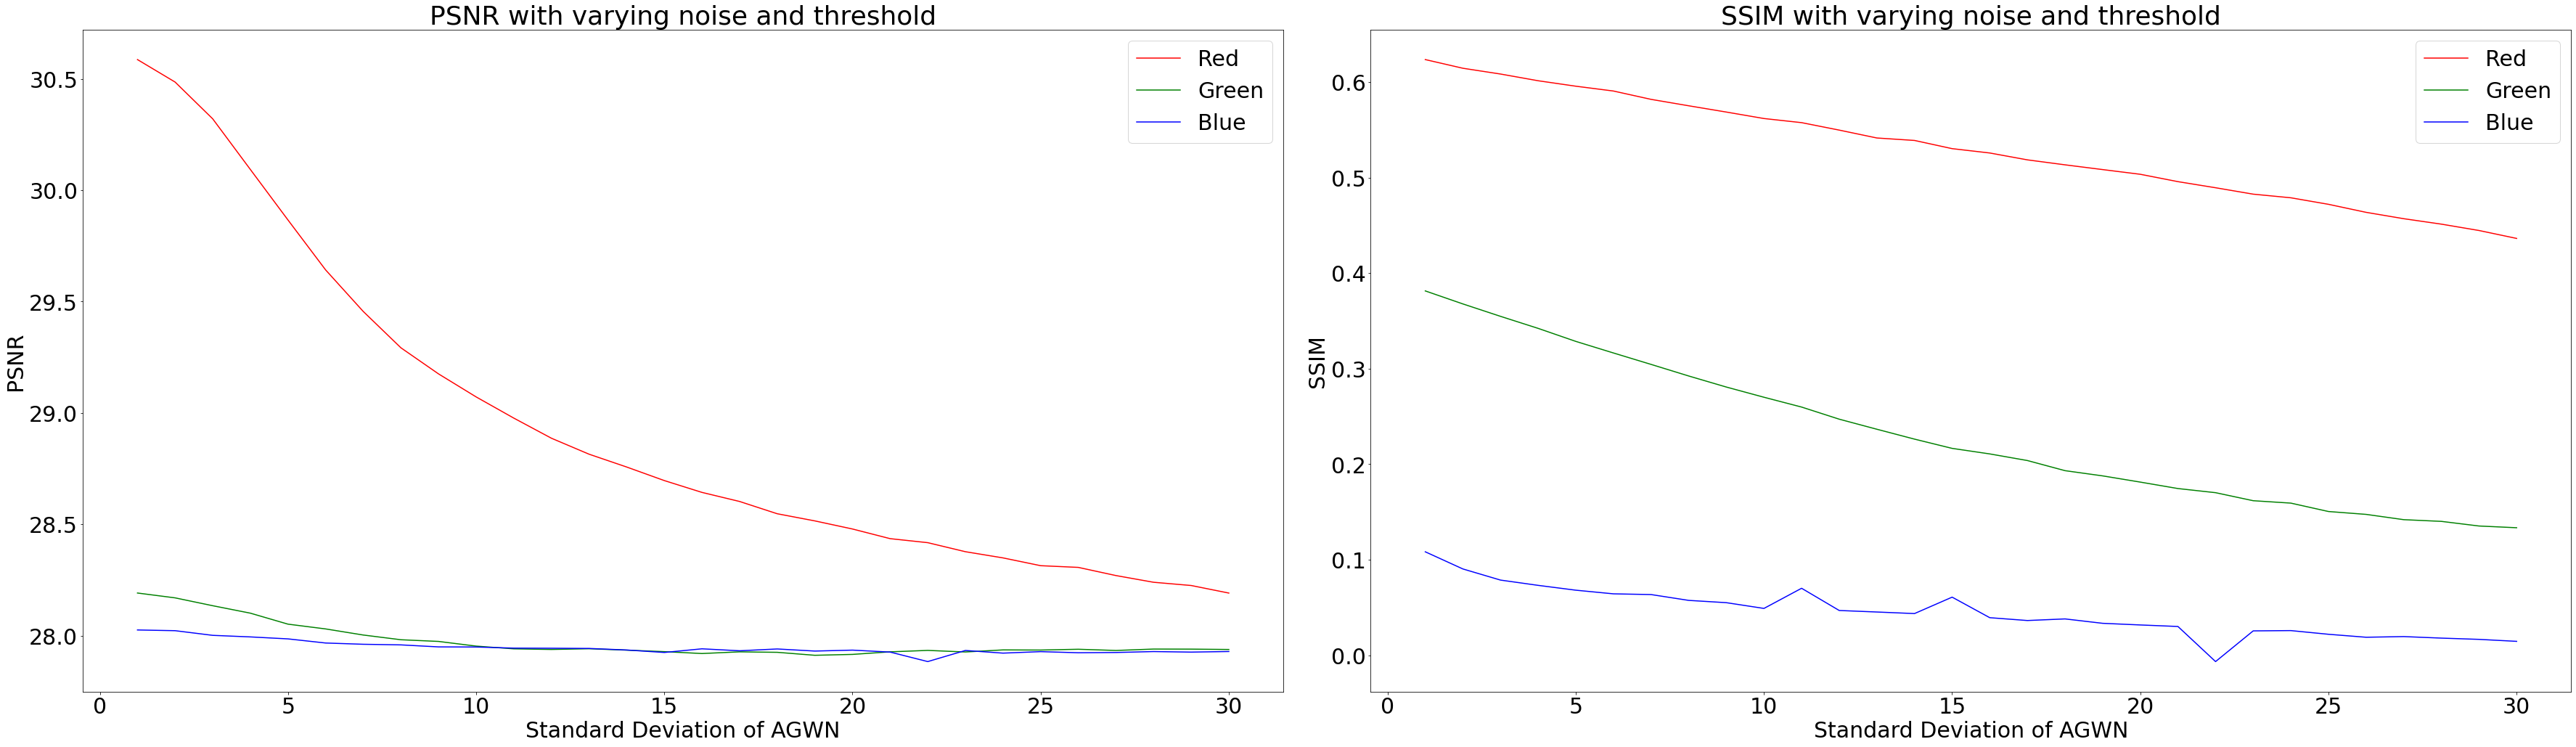

In [191]:
plot_chen_hsi(clean.copy()) 

### Similar to the trend in NeighShrink thresholding on RGB, the values of PSNR and SSIM decrease as the noise content in the image is increased. When compared to adding noise and thresholding in RGB, adding noise and thresholding the Intensity channel in HSI gives lesser values for PSNR and SSIM as thresholding done only on the image intensity produces less pronounced noise reduction

### Q4. Compare a few of the methods from part 3 on real noisy images, where noise variance is not known, by assuming various values of the noise variance as trial and error. [2]

As the noise variance of the original image is unknown, we can check for various values of variance and apply the NeighShrink thresholding method (which is the best method among the three)

In [136]:
clean = cv2.imread('1.jpeg') #Reading the image
dataset1 = clean.copy() #Copying into new image array
h, w, i = dataset1.shape #Stores the values of height and width of image in 'h' and 'w'
print("Height = {},  Width = {}, Intensity ={}".format(h, w, i)) #Prints height and width

Height = 362,  Width = 424, Intensity =3


![](1.jpeg)

Image with noise, credits https://www.google.com/url?sa=i&url=https%3A%2F%2Faishack.in%2Ftutorials%2Fnoise-reduction-averaging-theory%2F&psig=AOvVaw3dUmRXUuYHYbVkxMdsGvtn&ust=1665968218175000&source=images&cd=vfe&ved=0CA0QjRxqFwoTCLjq_6HT4_oCFQAAAAAdAAAAABAD

In [137]:
dataset1_b,dataset1_g,dataset1_r = color_array(dataset1) #Storing different intensity values in different arrays


dataset1_b_coeffs2 = pywt.dwt2(dataset1_b, 'db4') #Generating the Wavelet Coefficients for Blue channel
dataset1_g_coeffs2 = pywt.dwt2(dataset1_g, 'db4') #Generating the Wavelet Coefficients for Green channel
dataset1_r_coeffs2 = pywt.dwt2(dataset1_r, 'db4') #Generating the Wavelet Coefficients for Red channel

In [144]:
#We assume that the noise is gaussian (it may or may not be) with a standard deviation of 5
thres_donoho = donoho(5,362,424) #Calculating threshold as suggested by donoho
print(thres_donoho)

#Generating the image by performing thresholding by the NeighShrink Method 
dataset1_img_chen_5 = chen_thres_img(dataset1_b_coeffs2,dataset1_g_coeffs2, dataset1_r_coeffs2, thres_donoho)

cv2.imwrite('dataset1_chen_5.jpeg',dataset1_img_chen_5) #Saves the image

24.434993009061543


True

![](dataset1_chen_5.jpeg)

The image looks cleaner but still has significant amount of noise, lets increase the threshold

In [145]:
#Now we assume that the noise is gaussian (it may or may not be) with a standard deviation of 10
thres_donoho = donoho(10,362,424) #Calculating threshold as suggested by donoho
print(thres_donoho)

#Generating the image by performing thresholding by the NeighShrink Method 
dataset1_img_chen_10 = chen_thres_img(dataset1_b_coeffs2,dataset1_g_coeffs2, dataset1_r_coeffs2, thres_donoho)

cv2.imwrite('dataset1_chen_10.jpeg',dataset1_img_chen_10) #Saves the image

48.869986018123086


True

![](dataset1_chen_10.jpeg)

Increasing the threshold by assuming noise standard deviation to be 10 has cleaned up significant noise, but better results can still be achieved. Lets increase the threshold further

In [147]:
#Now we assume that the noise is gaussian (it may or may not be) with a standard deviation of 15
thres_donoho = donoho(15,362,424) #Calculating threshold as suggested by donoho
print(thres_donoho)

#Generating the image by performing thresholding by the NeighShrink Method 
dataset1_img_chen_15 = chen_thres_img(dataset1_b_coeffs2,dataset1_g_coeffs2, dataset1_r_coeffs2, thres_donoho)

cv2.imwrite('dataset1_chen_15.jpeg',dataset1_img_chen_15) #Saves the image

73.30497902718463


True

![](dataset1_chen_15.jpeg)

The difference between this image and the previous one isn't much but still noise in some regions like the cat's fur has been reduced. 

In [148]:
#Now we assume that the noise is gaussian (it may or may not be) with a standard deviation of 20
thres_donoho = donoho(20,362,424) #Calculating threshold as suggested by donoho
print(thres_donoho)

#Generating the image by performing thresholding by the NeighShrink Method 
dataset1_img_chen_20 = chen_thres_img(dataset1_b_coeffs2,dataset1_g_coeffs2, dataset1_r_coeffs2, thres_donoho)

cv2.imwrite('dataset1_chen_20.jpeg',dataset1_img_chen_20) #Saves the image

97.73997203624617


True

![](dataset1_chen_20.jpeg)

This image and the one above look nearly identical to the eye in noise signature. If we increase the threshold any further, we may start to see loss in detail without much noise reduction.

In [149]:
#Now we assume that the noise is gaussian (it may or may not be) with a standard deviation of 30
thres_donoho = donoho(30,362,424) #Calculating threshold as suggested by donoho
print(thres_donoho)

#Generating the image by performing thresholding by the NeighShrink Method 
dataset1_img_chen_30 = chen_thres_img(dataset1_b_coeffs2,dataset1_g_coeffs2, dataset1_r_coeffs2, thres_donoho)

cv2.imwrite('dataset1_chen_30.jpeg',dataset1_img_chen_30) #Saves the image

146.60995805436926


True

![](dataset1_chen_30.jpeg)

The image thresholded with assumed noise standard deviation = 30 has similar noise as to the image with assumed noise standard deviation = 20 but has slightly less apparent detail. The cat's whiskers look less detailed than the previous image. Incresing the threshold further will only result in loss of detail without significant noise reduction

### References
- Digital Image Processing by Gonzales and Woods
- An Introduction to Wavelets by Amara Graps, 1995 Institute of Electrical and Electronics Engineers, Inc
- IMAGE DENOISING USING NEIGHBOURING WAVELET COEFFICIENTS by Chen et al.
- NONLINEAR WAVELET DENOISING OF DATA SIGNALS by Zoltan German-Sallo
- PyWavelets (https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html)
- Geeks for Geeks and Stack Overflow to refer Python Syntax

### Footnotes
- All images were denoised by performing single level Discrete Wavelet Transform. As the Approximation image also has significant amount of noise, thresholding the detail coefficients and using the LL approximation doesn't produce the best possible results one can achieve by de-noising using wavelet transforms.
- Multiple level DWT is the superior technique to be employed for de-noising, as the LL approximation carrying the noise is much smaller, of the order 2^(-n) times the original. Thresholding the LH,HL and HH coefficients obtained at each level thereafter produces much better results.
- In Q4, a better technique would be to compare the values of SSIM and PSNR for each value of threshold with a with a segment of clean image or a noise-free region. The value of assumed variance which has maximum PSNR and SSIM with the clean segment will be the best denoised output. As the question stated that the image is a real noisy image, with no clean segment available, thresholding by trial and error is the only technique at hand. 